In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
from scipy.stats import gaussian_kde

## Technical Functions for channelIDs

In [4]:
def toGeo(x):
    #converts PETSys ID to geometric ID
    y = 8*indices.get(x)[0] + indices.get(x)[1]
    return y

indices = {
      0 : (4,7-7),
      1 : (4,7-6),
      2 : (7,7-5),
      3 : (5,7-7),
      4 : (5,7-4),
      5 : (5,7-5),
      6 : (4,7-4),
      7 : (7,7-7),
      8 : (6,7-6),
      9 : (7,7-4),
      10 : (5,7-6),
      11 : (6,7-4),
      12 : (4,7-5),
      13 : (6,7-5),
      14 : (6,7-7),
      15 : (7,7-6),
      16 : (3,7-7),
      17 : (3,7-6),
      18 : (2,7-7),
      19 : (2,7-6),
      20 : (0,7-7),
      21 : (1,7-7),
      22 : (0,7-6),
      23 : (1,7-6),
      24 : (3,7-5),
      25 : (1,7-5),
      26 : (2,7-5),
      27 : (4,7-3),
      28 : (0,7-5),
      29 : (3,7-4),
      30 : (0,7-4),
      31 : (1,7-4),
      32 : (2,7-4),
      33 : (3,7-3),
      34 : (2,7-3),
      35 : (0,7-3),
      36 : (1,7-3),
      37 : (0,7-2),
      38 : (5,7-3),
      39 : (1,7-2),
      40 : (2,7-2),
      41 : (3,7-2),
      42 : (1,7-1),
      43 : (0,7-1),
      44 : (0,7-0),
      45 : (3,7-1),
      46 : (1,7-0),
      47 : (2,7-1),
      48 : (3,7-0),
      49 : (2,7-0),
      50 : (6,7-2),
      51 : (6,7-1),
      52 : (7,7-1),
      53 : (4,7-1),
      54 : (5,7-1),
      55 : (6,7-0),
      56 : (7,7-0),
      57 : (7,7-2),
      58 : (7,7-3),
      59 : (4,7-2),
      60 : (5,7-0),
      61 : (5,7-2),
      62 : (6,7-3),
      63 : (4,7-0),
      64:(3+8,7),
      65:(3+8,6),
      66:(2+8,4),
      67:(2+8,6),
      68:(3+8,4),
      69:(1+8,7),
      70:(1+8,5),
      71:(0+8,7),
      72:(1+8,6),
      73:(3+8,3),
      74:(2+8,7),
      75:(2+8,3),
      76:(3+8,5),
      77:(0+8,5),
      78:(2+8,5),
      79:(0+8,6),
      80:(4+8,7),
      81:(6+8,7),
      82:(5+8,7),
      83:(7+8,7),
      84:(5+8,6),
      85:(4+8,6),
      86:(6+8,6),
      87:(7+8,6),
      88:(4+8,5),
      89:(6+8,5),
      90:(5+8,5),
      91:(1+8,4),
      92:(7+8,5),
      93:(7+8,4),
      94:(6+8,4),
      95:(4+8,4),
      96:(5+8,4),
      97:(5+8,3),
      98:(6+8,3),
      99:(4+8,3),
      100:(7+8,3),
      101:(7+8,2),
      102:(0+8,4),
      103:(6+8,2),
      104:(7+8,1),
      105:(5+8,2),
      106:(6+8,1),
      107:(4+8,2),
      108:(7+8,0),
      109:(5+8,1),
      110:(6+8,0),
      111:(4+8,1),
      112:(5+8,0),
      113:(4+8,0),
      114:(0+8,2),
      115:(2+8,1),
      116:(0+8,1),
      117:(3+8,1),
      118:(1+8,1),
      119:(1+8,0),
      120:(0+8,0),
      121:(1+8,2),
      122:(1+8,3),
      123:(3+8,2),
      124:(2+8,0),
      125:(2+8,2),
      126:(0+8,3),
      127:(3+8,0)}

geo_channels = []
for i in range(128):
    geo_channels.append([i,toGeo(i)])
geo_channels = np.asarray(geo_channels)

def toGeoChannelID(AbsChannelID):
    # Convert PETSys absolute channel IDs to geomteric IDs
    slaveID = AbsChannelID // 4096
    chipID = (AbsChannelID - slaveID*4096) // 64
    channelID = AbsChannelID % 64

    PCB_ChanID = 64*(chipID % 2) + channelID
    AbsPCB_ChanID = geo_channels[geo_channels[:,0] == PCB_ChanID][0][1]

    #General formula can be found in above function "to AbsChannelID"
    GeoChannelID = 10**4 * slaveID + 10**2 * chipID + AbsPCB_ChanID % 64
    return GeoChannelID

def toRecoChannelID(AbsChannelID):
    portID = AbsChannelID // 131072 # new
    slaveID = (AbsChannelID - 131072*portID) // 4096
    chipID = (AbsChannelID - 4096*slaveID - 131072*portID) // 64
    channelID = AbsChannelID % 64
    RecoChannelID = 3072*portID + 1024*slaveID + 64*chipID + channelID
    return RecoChannelID

## Data Read-in functions

In [5]:
def getDoubleCoincidenceDataFrame(file,toGeo = True,convert_time_units = 1,chunksize = None):
    df = pd.read_csv(file,sep='\t',usecols=[2,3,4,7,8,9],chunksize = chunksize)
    df.columns = ['TimeL', 'ChargeL', 'ChannelIDL', 'TimeR', 'ChargeR', 'ChannelIDR']
    
    if toGeo == True:
        df["ChannelIDL"] = df["ChannelIDL"] .apply(toGeoChannelID)
        df["ChannelIDR"] = df["ChannelIDR"] .apply(toGeoChannelID)
    
    df['TimeL'] = df['TimeL'] * convert_time_units
    df['TimeR'] = df['TimeR'] * convert_time_units
    
    return df

def getTripleCoincidenceDataFrame(file,toGeo = True,dropDuplicates = True,convert_time_units = 1):
    df = pd.read_csv(file,sep='\t',usecols=[2,3,4,7,8,9,12,13,14])
    df.columns = ['Time1', 'Charge1', 'ChannelID1', 'Time2','Charge2','ChannelID2','Time3', 'Charge3','ChannelID3']
    
    if toGeo == True:
        df["ChannelID1"] = df["ChannelID1"].apply(toGeoChannelID)
        df["ChannelID2"] = df["ChannelID2"].apply(toGeoChannelID)
        df["ChannelID3"] = df["ChannelID3"].apply(toGeoChannelID)
        
    if dropDuplicates == True:
        df = df[df['ChannelID1'] != df['ChannelID2']]
        df = df[df['ChannelID1'] != df['ChannelID3']]
        df = df[df['ChannelID2'] != df['ChannelID3']]
        
    df['Time1'] = df['Time1'] * convert_time_units
    df['Time2'] = df['Time2'] * convert_time_units
    df['Time3'] = df['Time3'] * convert_time_units
    
    return df

## Math Functions

In [6]:
def gaussian(x,A,mu,sig):
    return A * np.exp(-((x-mu)/sig)**2)

def getAngle(v1,v2):
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    numer = np.dot(v1,v2)
    denom = mag_v1 * mag_v2
    theta = np.arccos(numer/denom)
    return theta

def additionErrorPropagation(errlist):
    err = np.sqrt(np.sum([x**2 for x in errlist]))
    return err

# a big function but it works and not too slow!
# projection = 'xy','xz','yz', or 'xyz'
# ONLY USEFUL FOR ISOCENTER RUNS
# this will be turned into a script on its own outside of jupyter because it will serve as a geometric cutting tool
def getMomentumAngles(df,projection,inDegrees = True):
    theta12_ = []
    theta23_ = []
    theta13_ = []
    
    energy1_ = []
    energy2_ = []
    energy3_ = []
    
    projection = 'xy'
    
    for i in tqdm(energycutdf.index):  
        tempdf = energycutdf[energycutdf.index == i]
    
        try:
    
            ch1 = tempdf.ChannelID1.iloc[0]
            ch2 = tempdf.ChannelID2.iloc[0]
            ch3 = tempdf.ChannelID3.iloc[0]
    
            # get charge corresponding to each channel
            ene1 = tempdf.Charge1.iloc[0]
            ene2 = tempdf.Charge2.iloc[0]
            ene3 = tempdf.Charge3.iloc[0]
    
            geoCoinc1 = geo[geo.index == ch1]
            x1 = geoCoinc1.x.iloc[0]
            y1 = geoCoinc1.y.iloc[0]
            z1 = geoCoinc1.z.iloc[0]
    
    
            geoCoinc2 = geo[geo.index == ch2]
            x2 = geoCoinc2.x.iloc[0]
            y2 = geoCoinc2.y.iloc[0]
            z2 = geoCoinc2.z.iloc[0]
    
    
            geoCoinc3 = geo[geo.index == ch3]
            x3 = geoCoinc3.x.iloc[0]
            y3 = geoCoinc3.y.iloc[0]
            z3 = geoCoinc3.z.iloc[0]
    
            if projection == 'xy':
                theta12_.append(getAngle([x1,y1],[x2,y2]))
                theta23_.append(getAngle([x2,y2],[x3,y3]))
                theta13_.append(getAngle([x1,y1],[x3,y3]))
                energy1_.append(ene1)
                energy2_.append(ene2)
                energy3_.append(ene3)
                
            elif projection == 'xz':
                theta12_.append(getAngle([x1,z1],[x2,z2]))
                theta23_.append(getAngle([x2,z2],[x3,z3]))
                theta13_.append(getAngle([x1,z1],[x3,z3]))
            elif projection == 'yz':
                theta12_.append(getAngle([y1,z1],[y2,z2]))
                theta23_.append(getAngle([y2,z2],[y3,z3]))
                theta13_.append(getAngle([y1,z1],[y3,z3]))
            else:
                theta12_.append(getAngle([x1,y1,z1],[x2,y2,z2]))
                theta23_.append(getAngle([x2,y2,z2],[x3,y3,z3]))
                theta13_.append(getAngle([x1,y1,z1],[x3,y3,z3]))
    
        except:
            pass 
    
    ''' 
    
    code below to drop nans... still debugging why some angles cant be computed but realistically if an
    angle could not be calculated its probably because it was a nonsensical LOR anyway... 
    
    '''
    
    theta12_ = np.array(theta12_)
    nans12 = np.argwhere(np.isnan(theta12_)).flatten()
    theta23_ = np.array(theta23_)
    nans23 = np.argwhere(np.isnan(theta23_)).flatten()
    theta13_ = np.array(theta13_)
    nans13 = np.argwhere(np.isnan(theta13_)).flatten()
    nans = np.unique(np.concatenate((nans12,nans23,nans13)))
    theta12_ = np.delete(theta12_,nans)
    theta23_ = np.delete(theta23_,nans)
    theta13_ = np.delete(theta13_,nans)
    energy1_ = np.delete(energy1_,nans)
    energy2_ = np.delete(energy2_,nans)
    energy3_ = np.delete(energy3_,nans)
    
    if inDegrees == True:
        theta12_,theta23_,theta13_ = theta12_*180/np.pi,theta23_*180/np.pi,theta13_*180/np.pi

    return pd.DataFrame({"Theta12":theta12_,
                        "Theta23":theta23_,
                        "Theta13":theta13_,
                        "Energy1":energy1_,
                        "Energy2":energy2_,
                        "Energy3":energy3_,})

## Analysis and Visualization Functions

In [7]:
# bins should be put in as a list as [number of bins, min_value,max_value]
def getDoubleCoincidenceEnergySpectrum(df,channelID,bins,guess = [1,1,1],fitcut = True,display = False):
    fig,ax = plt.subplots()
       
    if channelID in np.unique(df.ChannelIDL):
        df_by_chan = df[df.ChannelIDL == channelID]
        energy = df_by_chan.ChargeL.to_numpy()
    
    else:
        df_by_chan = df[df.ChannelIDR == channelID]
        energy = df_by_chan.ChargeR.to_numpy()
    
    y,x = np.histogram(energy,bins[0],(bins[1],bins[2]))
    centers = (x[:-1] + x[1:]) / 2
    
    if fitcut == True:
        fitcut = centers[np.where(y == max(y))[0][0]] - 5
        energy_temp = energy[energy >= fitcut]
        y,x = np.histogram(energy_temp,bins[0],(bins[1],bins[2]))
        centers = (x[:-1] + x[1:]) / 2
    
    if guess == [1,1,1]:
        guess = [max(y),centers[np.where(y == max(y))[0][0]],np.std(energy_temp)]
        
    try:
        p,c = curve_fit(gaussian,centers,y,p0=guess)
        xspace = np.linspace(p[1]-2.5*p[2],p[1]+2.5*p[2],500)
        ax.plot(xspace,gaussian(xspace,*p),color = 'red')
        ax.hist(energy,bins = np.linspace(bins[1],bins[2],bins[0]),color = 'C0')
    except:
        p = [1,1,1]
        ('Fit Failed')
        
    if display == False:
        plt.close()
        
    return p

# using this w/ photoPeakFinder saves an insane amount of time!
# im talking a 5 hour run time to a 5 minute run time... 
def getStackedDoubleDataFrame(olddf):
    leftdf = olddf[["TimeL","ChargeL","ChannelIDL"]]
    leftdf.columns = ['Time','Charge','ChannelID']
    rightdf = olddf[["TimeR","ChargeR","ChannelIDR"]]
    rightdf.columns = ['Time','Charge','ChannelID']
    df = pd.concat([leftdf,rightdf])
    df.index = np.arange(0,np.shape(df)[0],1)
    return df

# depreciated for use w/ normal double coincidence frames
# must be used with a stacked dataframe! 
def photoPeakFinder(stacked_df,channelID,bins,guess = [1,1,1]):

    df_by_chan = stacked_df[stacked_df.ChannelID == channelID]
    energy = df_by_chan.Charge.to_numpy()
    
    y,x = np.histogram(energy,bins[0],(bins[1],bins[2]))
    centers = (x[:-1] + x[1:]) / 2
    
    fitcut = centers[np.where(y == max(y))[0][0]] - 5
    energy_temp = energy[energy >= fitcut]
    y,x = np.histogram(energy_temp,bins[0],(bins[1],bins[2]))
    
    centers = (x[:-1] + x[1:]) / 2
    
    if guess == [1,1,1]:
        guess = [max(y),centers[np.where(y == max(y))[0][0]],np.std(energy_temp)]
        
    try:
        p,c = curve_fit(gaussian,centers,y,p0=guess)
    except:
        p = [1,1,1]
        
    return p
    
def histProjection(data1,data2,bins,labels = ['','']):
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.02, hspace=0.02)
    ax = fig.add_subplot(gs[1, 0])

    # plot theta_nk vs theta_nl
    ax.hist2d(data1,data2,bins = bins)
    ax.set_xlabel(labels[0],fontsize = 19)
    ax.tick_params('x',labelsize = 14)
    ax.set_ylabel(labels[1],fontsize = 19)
    ax.tick_params('y',labelsize = 14)

    # create x & y projection histograms
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    ax_histx.hist(data1,bins = bins)
    ax_histy.hist(data2, orientation='horizontal',bins = bins)
    plt.setp(ax_histx.get_xticklabels(), visible=False) 
    ax_histx.tick_params('y',labelsize = 14)
    plt.setp(ax_histy.get_yticklabels(), visible=False) 
    ax_histy.tick_params('x',labelsize = 14)
    plt.show()

# same thing as histProjection but scatter plot weighted by density
# sometimes nicer for visualization but very computational expensive for large datasets, so use w/ caution or small subsets
# seriously **DO NOT USE** for any large datasets... 
def scatterProjection(data1,data2,bins,labels = ['','']):
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.02, hspace=0.02)
    ax = fig.add_subplot(gs[1, 0])

    # Calculate the point density
    xy = np.vstack([data1,data2])
    density = gaussian_kde(xy)(xy)
    
    ax.scatter(data1,data2,c=density)
    ax.set_xlabel(labels[0],fontsize = 19)
    ax.tick_params('x',labelsize = 14)
    ax.set_ylabel(labels[1],fontsize = 19)
    ax.tick_params('y',labelsize = 14)

    # create x & y projection histograms
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    ax_histx.hist(data1,bins = bins)
    ax_histy.hist(data2, orientation='horizontal',bins = bins)
    plt.setp(ax_histx.get_xticklabels(), visible=False) 
    ax_histx.tick_params('y',labelsize = 14)
    plt.setp(ax_histy.get_yticklabels(), visible=False) 
    ax_histy.tick_params('x',labelsize = 14)
    plt.show()

## Pre-Processing the data
- Define our dataframe 
- convert channels to recoID for mapping 
- drop triple coincidences that use the same channel twice

In [10]:
df = getTripleCoincidenceDataFrame('positronium_button_Run1_trips_coinc.dat',toGeo = False)

In [11]:
df["ChannelID1"] = df["ChannelID1"].apply(toRecoChannelID)
df["ChannelID2"] = df["ChannelID2"].apply(toRecoChannelID)
df["ChannelID3"] = df["ChannelID3"].apply(toRecoChannelID)

In [14]:
# drop triple coincidences in which 
df = df[df['ChannelID1'] != df['ChannelID2']]
df = df[df['ChannelID1'] != df['ChannelID3']]
df = df[df['ChannelID2'] != df['ChannelID3']]

## Taking a look at the aggregate energy spectra

In [15]:
charge1 = df.Charge1.to_numpy()
charge2 = df.Charge2.to_numpy()
charge3 = df.Charge3.to_numpy()
sumCharge = charge1 + charge2 + charge3

Text(0.65, 0.8, 'std: 6.9')

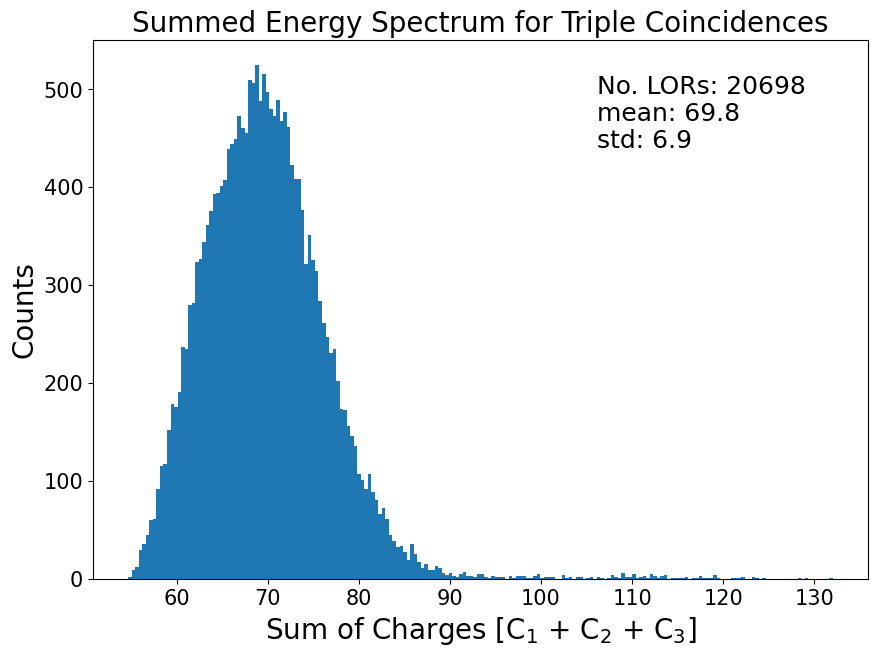

In [16]:
# fully summed energy spectrum for all triple coincidences - no energy cut 
fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = ax.hist(sumCharge,bins = 200)
ax.set_xlabel('Sum of Charges [C$_1$ + C$_2$ + C$_3$]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Summed Energy Spectrum for Triple Coincidences',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(sumCharge))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(sumCharge),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(sumCharge),1)),fontsize = 18,transform = ax.transAxes)

## individual charge spectra

Text(0.65, 0.8, 'std: 3.8')

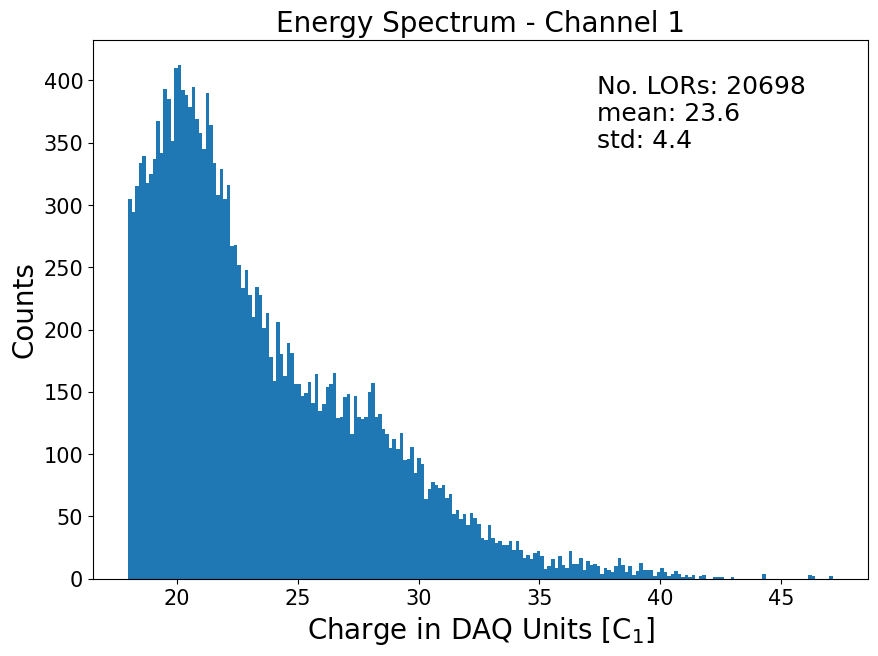

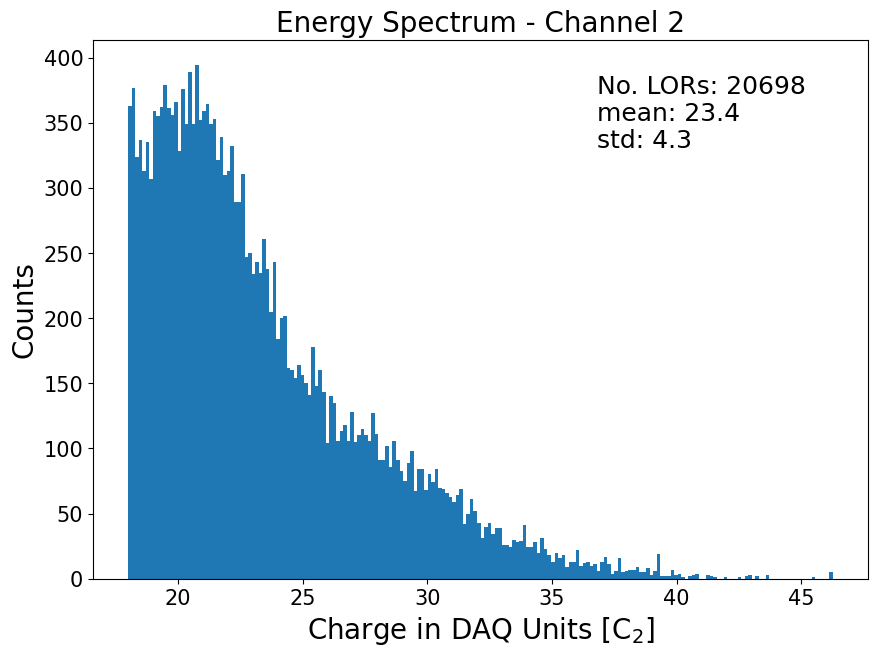

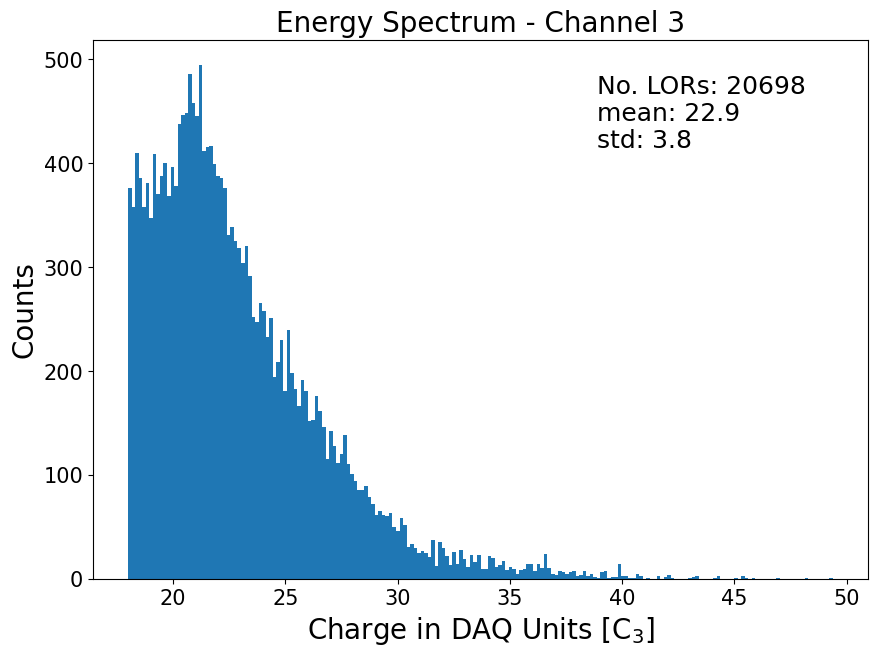

In [17]:
fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = ax.hist(charge1,bins = 200)
ax.set_xlabel('Charge in DAQ Units [C$_1$]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Energy Spectrum - Channel 1',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(charge1))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(charge1),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(charge1),1)),fontsize = 18,transform = ax.transAxes)

fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = ax.hist(charge2,bins = 200)
ax.set_xlabel('Charge in DAQ Units [C$_2$]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Energy Spectrum - Channel 2',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(charge2))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(charge2),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(charge2),1)),fontsize = 18,transform = ax.transAxes)

fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = ax.hist(charge3,bins = 200)
ax.set_xlabel('Charge in DAQ Units [C$_3$]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Energy Spectrum - Channel 3',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(charge3))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(charge3),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(charge3),1)),fontsize = 18,transform = ax.transAxes)

## Reading in the map of channelIDs | useful for momentum reconstruction

In [19]:
geo = pd.read_csv('Positronium/TPPT-Geo.csv',usecols = [0,1,2])
geo.columns = ['x','y','z']

# get the natural limits for the scanner image 
fig,ax = plt.subplots()
ax.plot(geo.x,geo.y)
xlims = list(ax.get_xlim()) 
ylims = list(ax.get_ylim())
plt.close()

## Phase Space representations w/ 2 Variables (Dalitz plots)

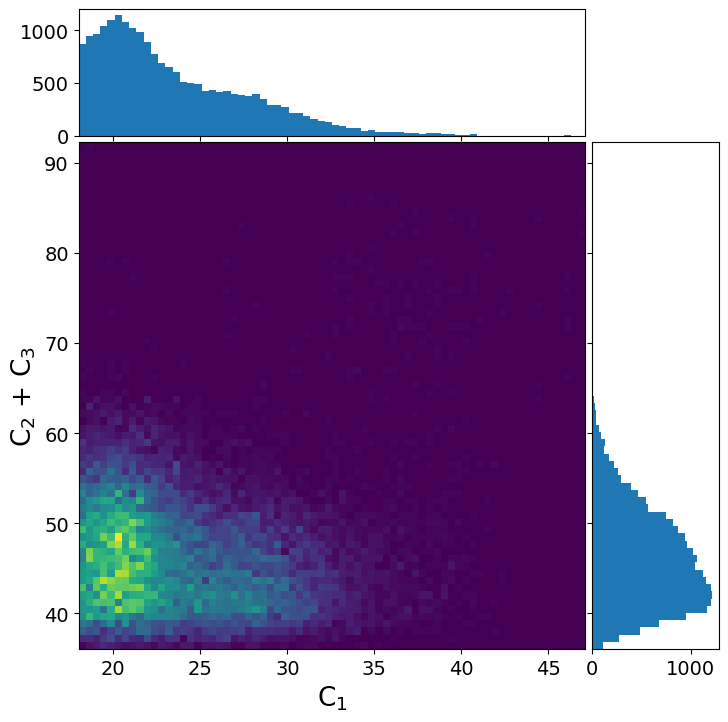

In [20]:
# Energy as our 2 variables
histProjection(charge1,charge2+charge3,bins = 70,labels = ['C$_1$','C$_2$ + C$_3$'])

## Finding relative 511 keV in DAQ units for every channel pair in the triple coincidence data

In [21]:
# read in double coincidence data frame
file = "positronium_button_double_coinc.dat"
doubleCoincDf  = pd.read_csv(file,sep='\t',usecols=[2,3,4,7,8,9],chunksize = 10000000)

framelist = []
for frames in doubleCoincDf:
    framelist.append(frames)
doubleCoincDf = pd.concat(framelist)
doubleCoincDf.columns = ['TimeL', 'ChargeL', 'ChannelIDL', 'TimeR', 'ChargeR', 'ChannelIDR']

# this takes awhile *sigh* but is necessary.. Positronium analysis should always be done in recoID
doubleCoincDf["ChannelIDL"] = doubleCoincDf["ChannelIDL"].apply(toRecoChannelID)
doubleCoincDf["ChannelIDR"] = doubleCoincDf["ChannelIDR"].apply(toRecoChannelID)

In [22]:
# get photopeak locations for every channel across all triple LORs
save_as_csv = False
photopeakDict = {"Channel":[],"Photopeak Location":[],'std':[]}
triplecoincidencechannels = np.unique(np.concatenate((np.unique(df.ChannelID1),np.unique(df.ChannelID2),np.unique(df.ChannelID3))))
stackeddf = getStackedDoubleDataFrame(doubleCoincDf)

for chans in tqdm(triplecoincidencechannels):
    p = photoPeakFinder(stackeddf,chans,[100,0,40])
    photopeakDict["Channel"]+=[chans]
    photopeakDict["Photopeak Location"]+=[p[1]]
    photopeakDict["std"]+=[p[2]]
    
photopeakDf = pd.DataFrame(photopeakDict)
if save_as_csv == True:
    photopeakDf.to_csv('photopeakLocations.txt')
    

100%|██████████████████████████████████████| 5836/5836 [00:12<00:00, 478.06it/s]


## Create new dataset  of triple coincs that meet the total annhilation energy threshold within uncertainity

In [23]:
# grab triple coincidences that meet annhilation energy threshold
error = []
ene = []
sigma = 8
energycutdf = pd.DataFrame()
for trips in tqdm(df.index):
    tempdf = df[df.index == trips]
    ID1,ID2,ID3 = tempdf.ChannelID1.iloc[0],tempdf.ChannelID2.iloc[0],tempdf.ChannelID3.iloc[0]
    annhilationEnergy = 2/3*(photopeakDf[photopeakDf.Channel == ID1]["Photopeak Location"].iloc[0] + photopeakDf[photopeakDf.Channel == ID2]["Photopeak Location"].iloc[0] + photopeakDf[photopeakDf.Channel == ID3]["Photopeak Location"].iloc[0])
    uncertainity = 2/3*additionErrorPropagation([photopeakDf[photopeakDf.Channel == ID1]["std"].iloc[0]*sigma,photopeakDf[photopeakDf.Channel == ID2]["std"].iloc[0]*sigma,photopeakDf[photopeakDf.Channel == ID3]["std"].iloc[0]*sigma])
    
    ene.append(annhilationEnergy)
    error.append(uncertainity)
    
    totalCharge = tempdf.Charge1.iloc[0] + tempdf.Charge2.iloc[0] + tempdf.Charge3.iloc[0]
    # only accept triple coincidences whose summed energy meets the 2*photopeak threshold within some uncertainity
    if totalCharge >= annhilationEnergy - uncertainity and totalCharge <= annhilationEnergy + uncertainity:
        energycutdf = pd.concat([energycutdf,tempdf])
        
error_limits = np.mean(np.array(error)/np.array(ene) * 1022)
print('The required uncertainity is within ± {} keV of 1022 keV'.format(error_limits))

100%|███████████████████████████████████| 20698/20698 [00:11<00:00, 1777.96it/s]

The required uncertainity is within ± 416.39592137160093 keV of 1022 keV


## Looking back our energy spectra after the 2m$_{e}$c$^{2}$ energy cut

Text(0.65, 0.8, 'std: 6.9')

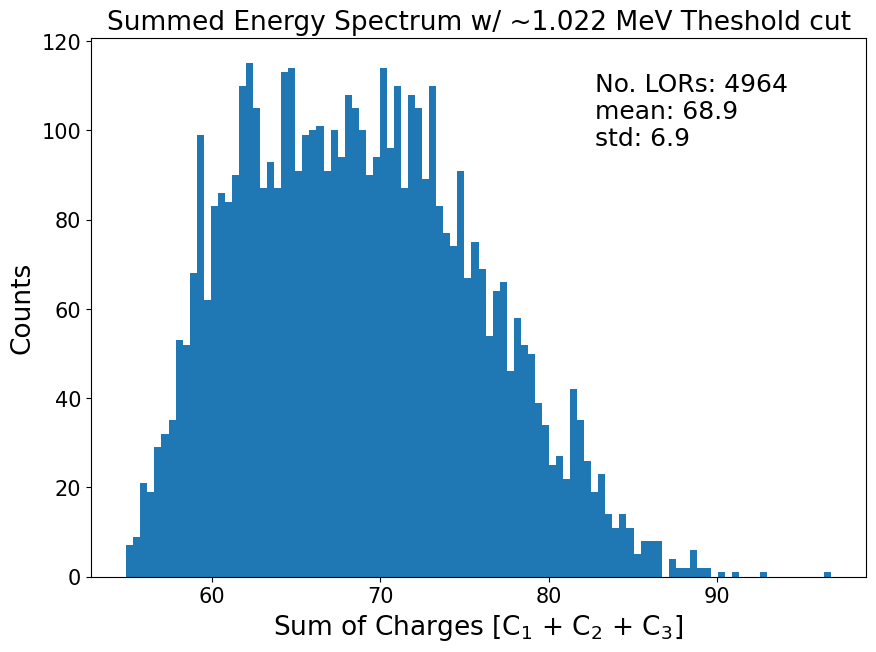

In [24]:
# let's see how the summed energy spectrum has changed
newCharge1,newCharge2,newCharge3 = energycutdf.Charge1,energycutdf.Charge2,energycutdf.Charge3
newSummedCharge = newCharge1 + newCharge2 + newCharge3
fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = plt.hist(newSummedCharge,bins = 100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Sum of Charges [C$_1$ + C$_2$ + C$_3$]',fontsize = 19)
plt.ylabel('Counts',fontsize = 19)
plt.title('Summed Energy Spectrum w/ ~1.022 MeV Theshold cut',fontsize = 19)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(newSummedCharge))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(newSummedCharge),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(newSummedCharge),1)),fontsize = 18,transform = ax.transAxes)

## individual energy spectra after the energy cut

Text(0.65, 0.8, 'std: 3.8')

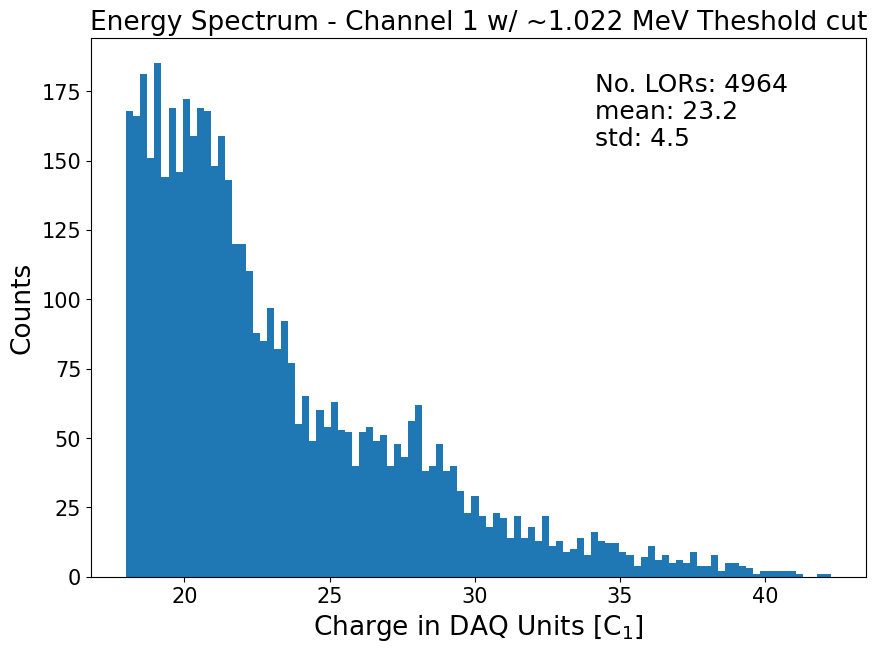

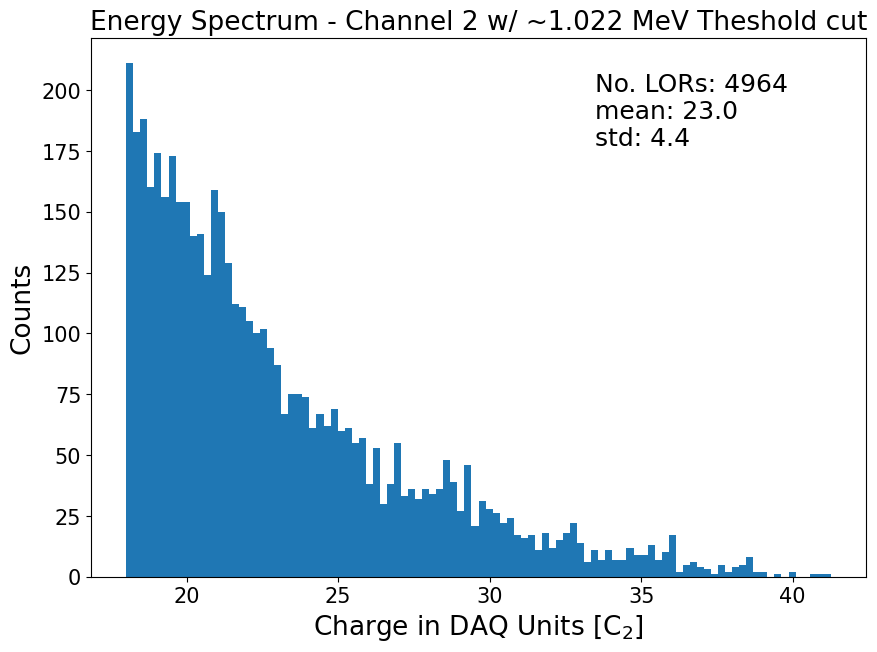

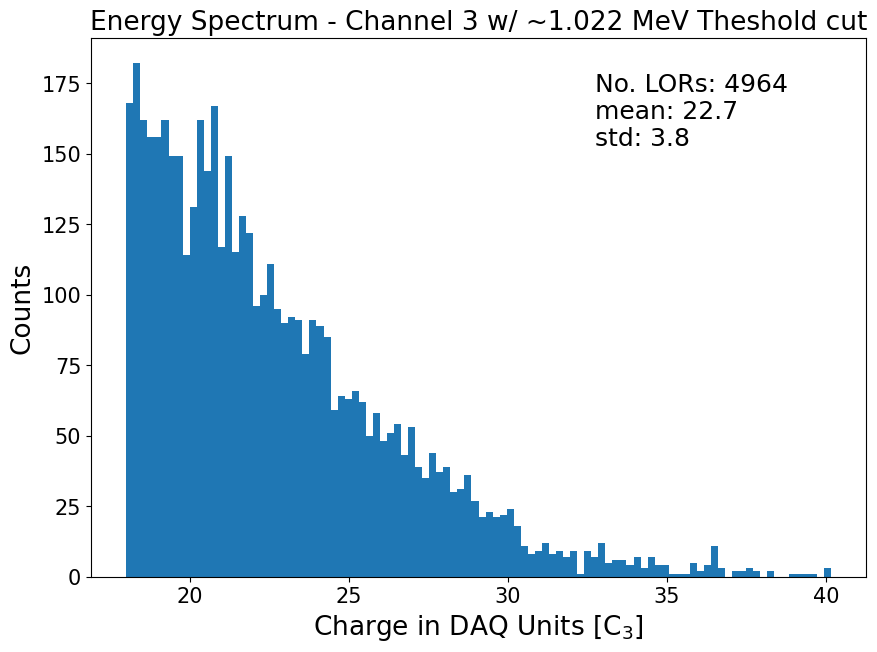

In [25]:
fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = plt.hist(newCharge1,bins = 100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Charge in DAQ Units [C$_1$]',fontsize = 19)
plt.ylabel('Counts',fontsize = 19)
plt.title('Energy Spectrum - Channel 1 w/ ~1.022 MeV Theshold cut',fontsize = 19)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(newCharge1))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(newCharge1),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(newCharge1),1)),fontsize = 18,transform = ax.transAxes)

fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = plt.hist(newCharge2,bins = 100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Charge in DAQ Units [C$_2$]',fontsize = 19)
plt.ylabel('Counts',fontsize = 19)
plt.title('Energy Spectrum - Channel 2 w/ ~1.022 MeV Theshold cut',fontsize = 19)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(newCharge2))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(newCharge2),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(newCharge2),1)),fontsize = 18,transform = ax.transAxes)

fig,ax = plt.subplots(figsize = (10,7))
y,x,_ = plt.hist(newCharge3,bins = 100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Charge in DAQ Units [C$_3$]',fontsize = 19)
plt.ylabel('Counts',fontsize = 19)
plt.title('Energy Spectrum - Channel 3 w/ ~1.022 MeV Theshold cut',fontsize = 19)
plt.text(0.65,0.9,'No. LORs: ' + str(int(len(newCharge3))),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(newCharge3),1)),fontsize = 18,transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(newCharge3),1)),fontsize = 18,transform = ax.transAxes)

### lets look at a single channel's spectrum before & after the energy cut

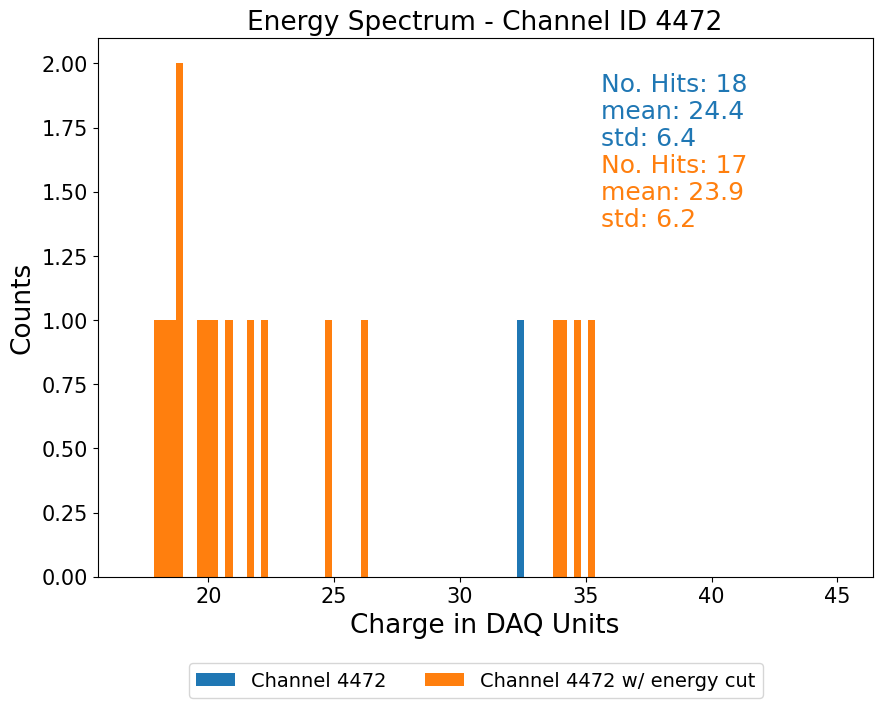

In [27]:
bins = np.linspace(17,45,100)
fig,ax = plt.subplots(figsize = (10,7))

chargenocut = df[df.ChannelID1 == 4472].Charge1
plt.hist(chargenocut,bins = bins,label = 'Channel 4472')

chargecut = energycutdf[energycutdf.ChannelID1 == 4472].Charge1
plt.hist(chargecut,bins = bins,label = 'Channel 4472 w/ energy cut')

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Charge in DAQ Units',fontsize = 19)
plt.ylabel('Counts',fontsize = 19)
plt.title('Energy Spectrum - Channel ID 4472',fontsize = 19)
plt.text(0.65,0.9,'No. Hits: ' + str(int(len(chargenocut))),fontsize = 18,color = 'C0',transform = ax.transAxes)
plt.text(0.65,0.85,'mean: ' + str(np.round(np.mean(chargenocut),1)),fontsize = 18,color = 'C0',transform = ax.transAxes)
plt.text(0.65,0.8,'std: ' + str(np.round(np.std(chargenocut),1)),fontsize = 18,color = 'C0',transform = ax.transAxes)
plt.text(0.65,0.75,'No. Hits: ' + str(int(len(chargecut))),fontsize = 18,color = 'C1',transform = ax.transAxes)
plt.text(0.65,0.7,'mean: ' + str(np.round(np.mean(chargecut),1)),fontsize = 18,color = 'C1',transform = ax.transAxes)
plt.text(0.65,0.65,'std: ' + str(np.round(np.std(chargecut),1)),fontsize = 18,color = 'C1',transform = ax.transAxes)
fig.legend(fontsize = 14,bbox_to_anchor = (0.8,.0),ncol = 2)

## Dalitz analysis before & after energy filtering 
* as 2D hists 

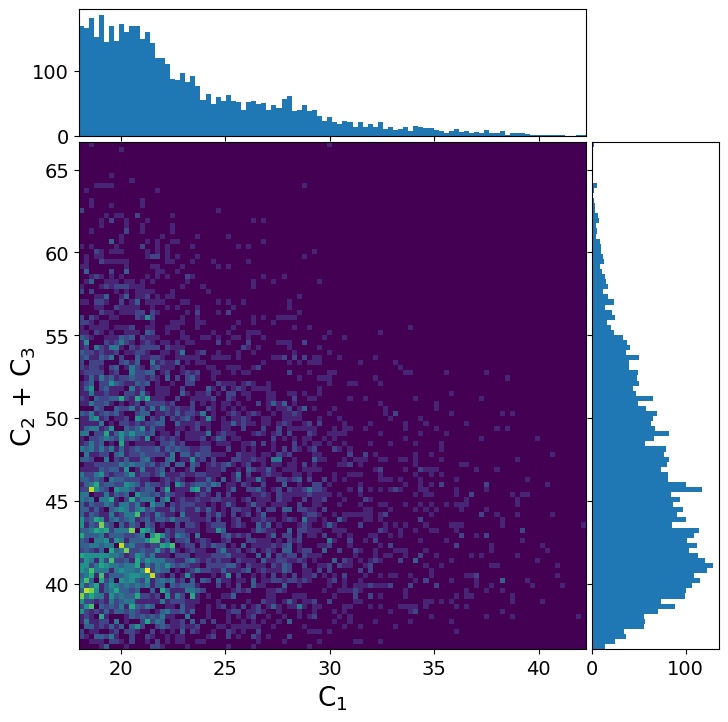

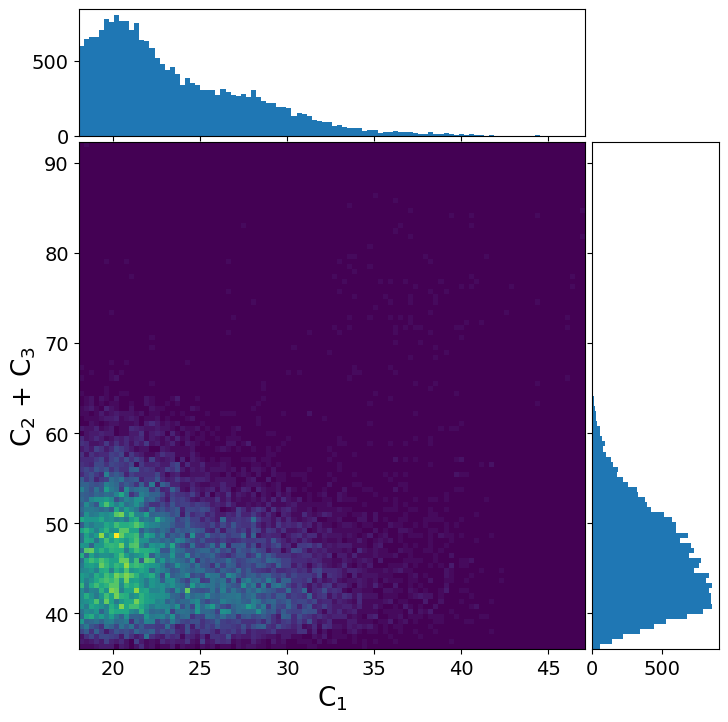

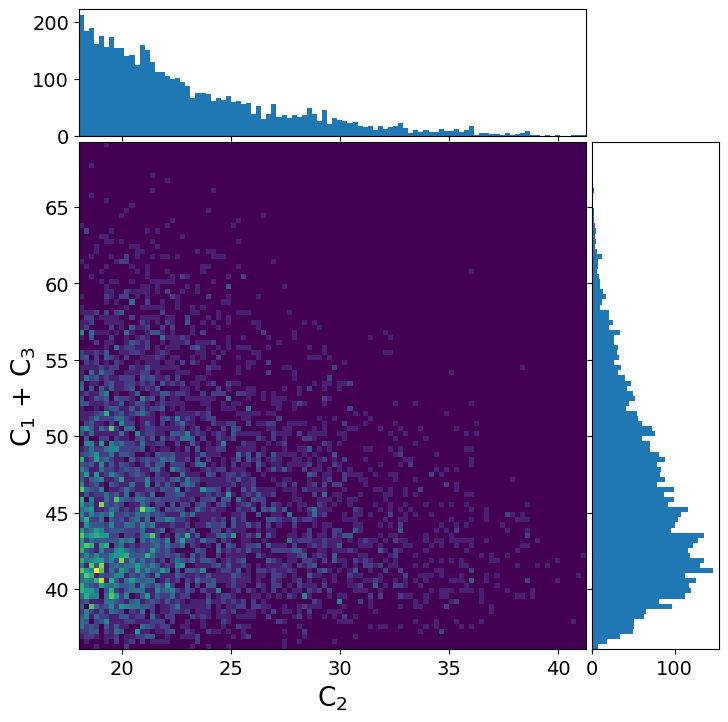

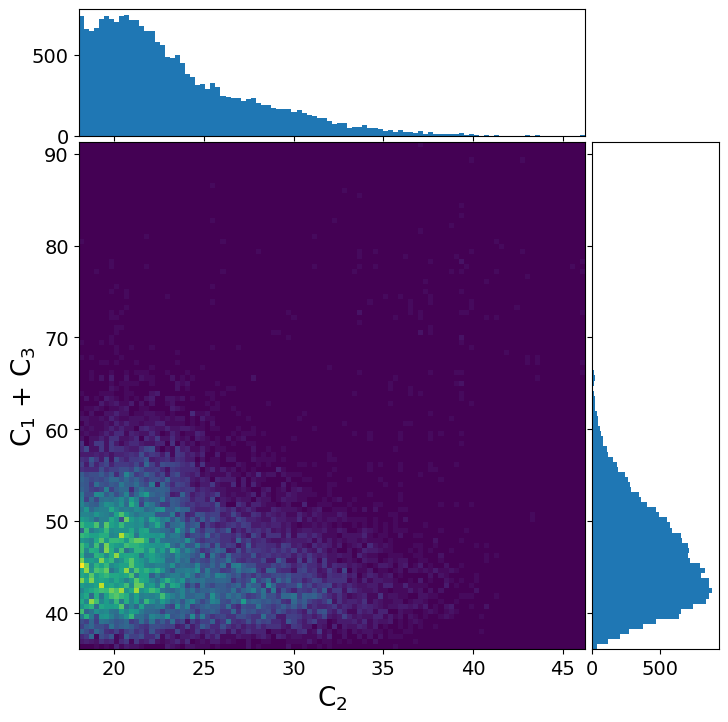

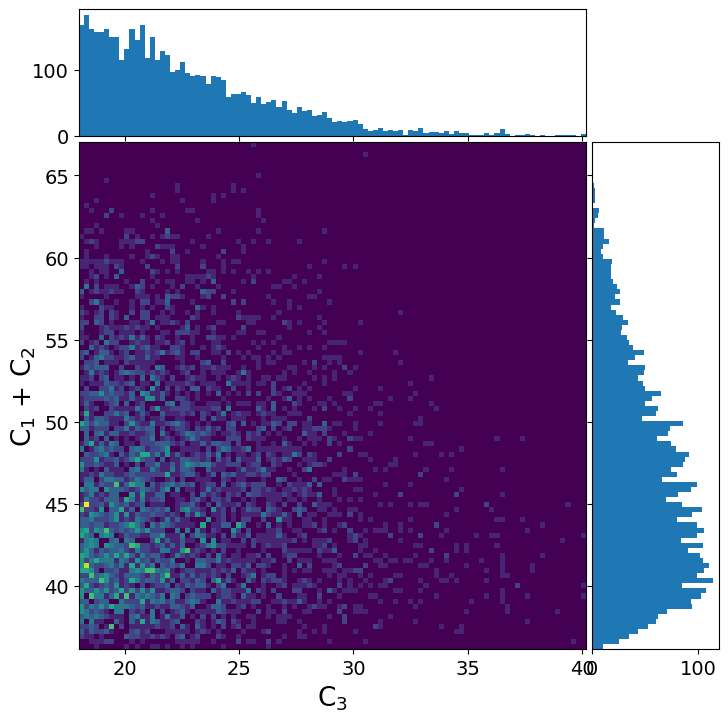

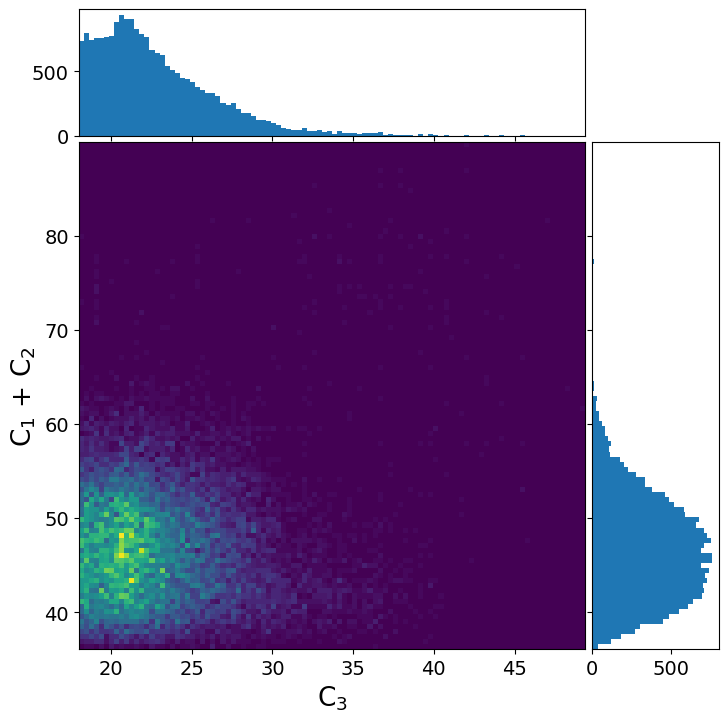

In [42]:
# now lets look at our Dalitz plots w/ the energy cut and without the annhilation energy cut

# C1 vs C2 + C3
histProjection(newCharge1,newCharge2+newCharge3,bins = 100,labels=[r'C$_1$',r'C$_2$ + C$_3$'])
histProjection(charge1,charge2+charge3,bins = 100,labels=[r'C$_1$',r'C$_2$ + C$_3$'])

# C2 vs C1 + C3
histProjection(newCharge2,newCharge1+newCharge3,bins = 100,labels=[r'C$_2$',r'C$_1$ + C$_3$'])
histProjection(charge2,charge1+charge3,bins = 100,labels=[r'C$_2$',r'C$_1$ + C$_3$'])

# C3 vs C1 + C2
histProjection(newCharge3,newCharge2+newCharge1,bins = 100,labels=[r'C$_3$',r'C$_1$ + C$_2$'])
histProjection(charge3,charge2+charge1,bins = 100,labels=[r'C$_3$',r'C$_1$ + C$_2$'])

## now lets look at our Dalitz plots w/ the energy cut as density scatter plots

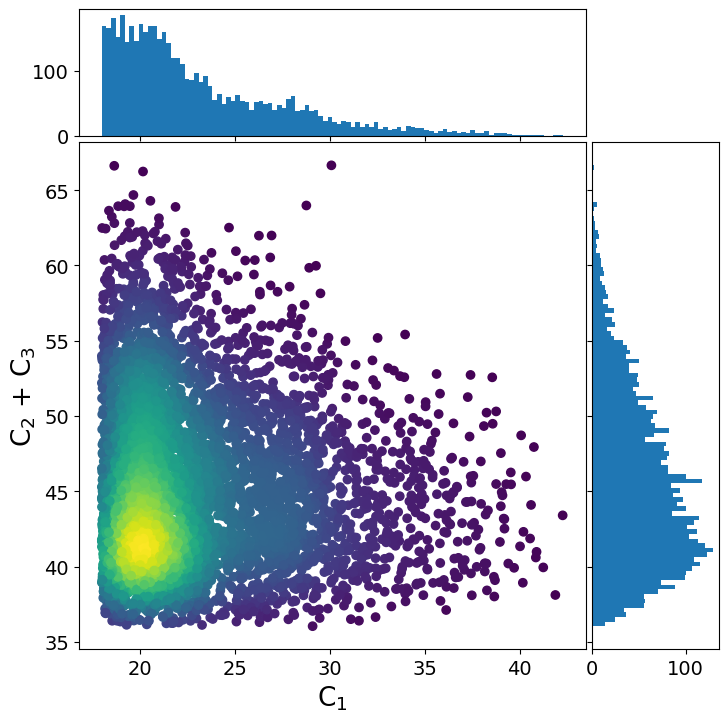

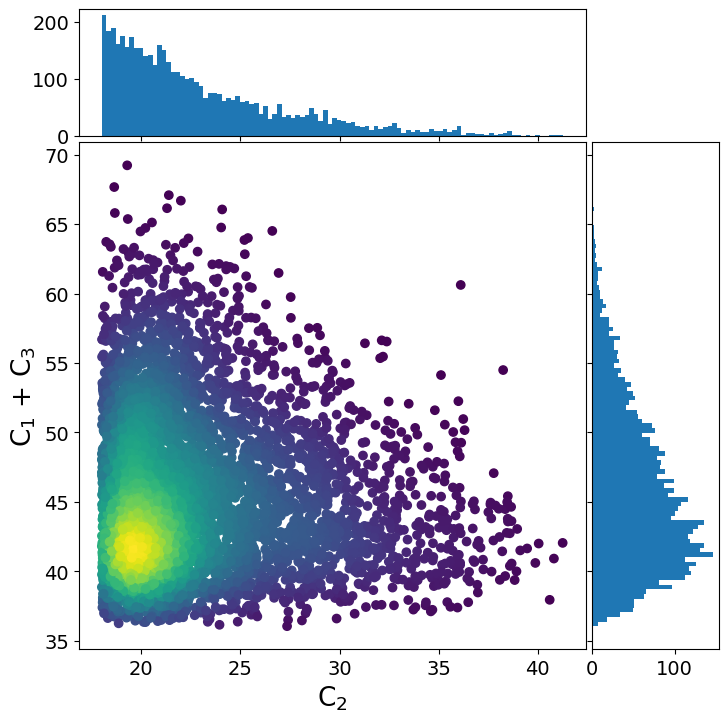

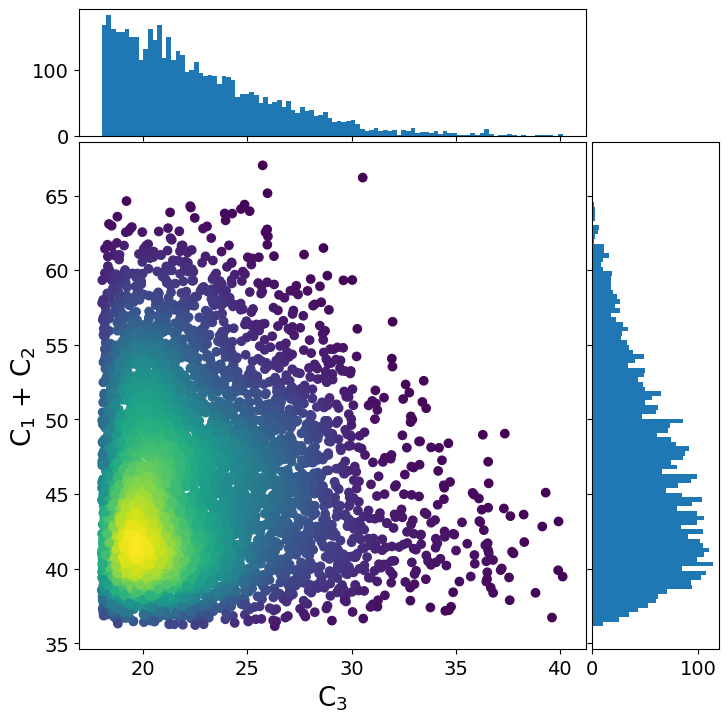

In [29]:
# C1 vs C2 + C3
scatterProjection(newCharge1,newCharge2+newCharge3,bins = 100,labels=[r'C$_1$',r'C$_2$ + C$_3$'])

# C2 vs C1 + C3
scatterProjection(newCharge2,newCharge1+newCharge3,bins = 100,labels=[r'C$_2$',r'C$_1$ + C$_3$'])

# C3 vs C1 + C2
scatterProjection(newCharge3,newCharge2+newCharge1,bins = 100,labels=[r'C$_3$',r'C$_1$ + C$_2$'])

## Time spectra before & after the energy cuts

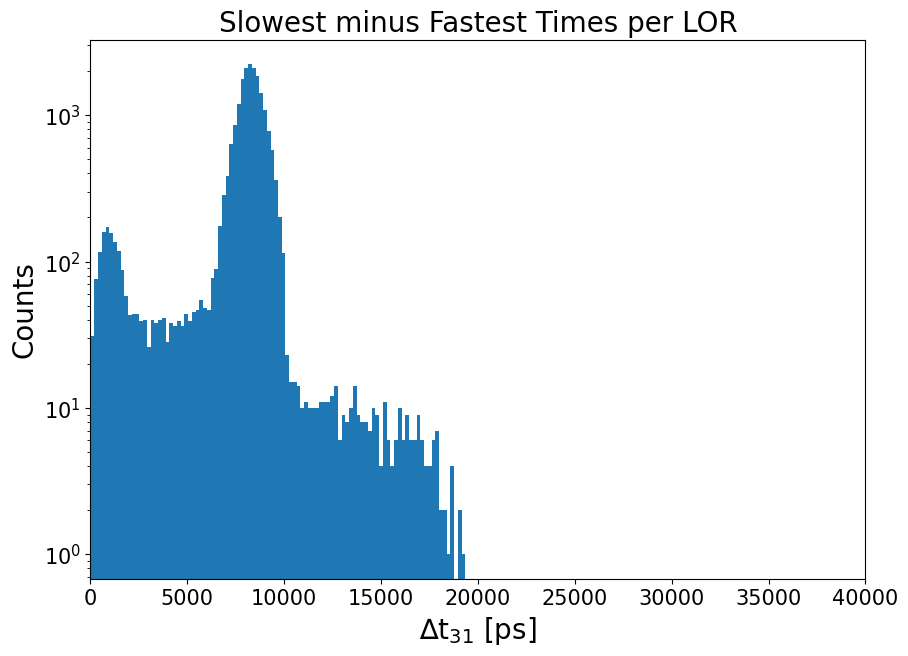

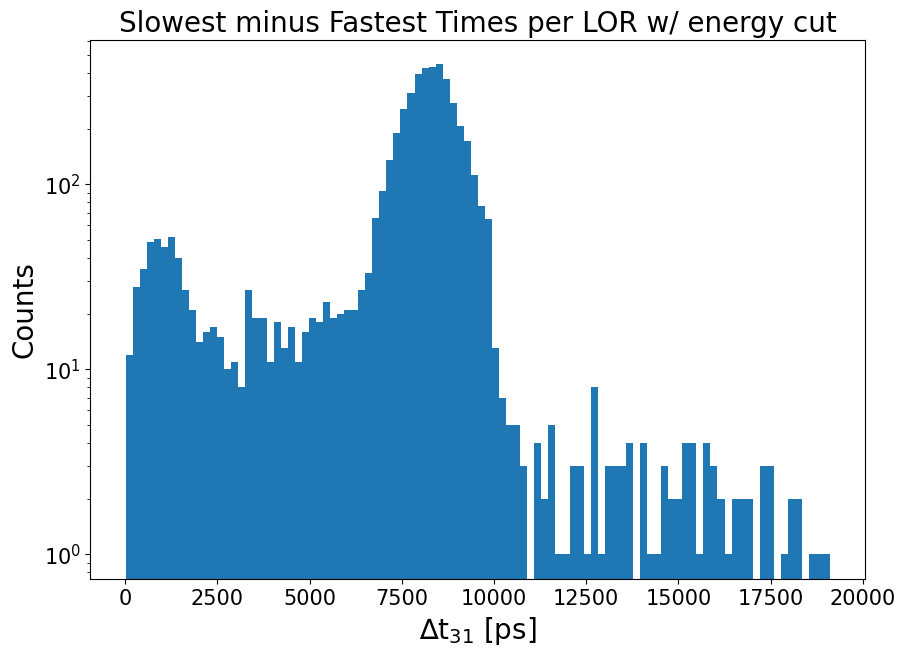

In [31]:
# first lets get all our times and order them from fastest to slowest!
dfarray = df.to_numpy()
dfTimes = dfarray[:,[0,3,6]]
dfTimes.sort(axis=1)

# without energy cut
fig,ax = plt.subplots(figsize = (10,7))
ax.set_xlabel('∆t$_{31}$ [ps]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Slowest minus Fastest Times per LOR',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.hist(dfTimes[:,2]-dfTimes[:,0],bins = 100)
plt.yscale('log')
plt.xlim(0,40000)
plt.show()

# with energy cut
fig,ax = plt.subplots(figsize = (10,7))
ax.set_xlabel('∆t$_{31}$ [ps]',fontsize = 20)
ax.set_ylabel('Counts',fontsize = 20)
plt.title('Slowest minus Fastest Times per LOR w/ energy cut',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
energycutdfarray = energycutdf.to_numpy()
energycutdfTimes = energycutdfarray[:,[0,3,6]]
energycutdfTimes.sort(axis=1)
plt.hist(energycutdfTimes[:,2]-energycutdfTimes[:,0],bins = 100)
plt.yscale('log')
plt.show()

## Momentum Reconstruction

In [32]:
# now let's get our angles
fourvector_frame_nocut = getMomentumAngles(df,projection = 'xy',inDegrees=True)
theta12_nocut = fourvector_frame_nocut.Theta12.to_numpy()
theta23_nocut = fourvector_frame_nocut.Theta23.to_numpy()
theta13_nocut = fourvector_frame_nocut.Theta13.to_numpy()

fourvector_frame = getMomentumAngles(energycutdf,projection = 'xy',inDegrees=True)
theta12 = fourvector_frame.Theta12.to_numpy()
theta23 = fourvector_frame.Theta23.to_numpy()
theta13 = fourvector_frame.Theta13.to_numpy()

  0%|                                                  | 0/4964 [00:00<?, ?it/s]/var/folders/0q/5c4bcz6n2jlc82f86_hqdm1m0000gn/T/ipykernel_98427/2621831605.py:9: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(numer/denom)
100%|█████████████████████████████████████| 4964/4964 [00:01<00:00, 3255.11it/s]


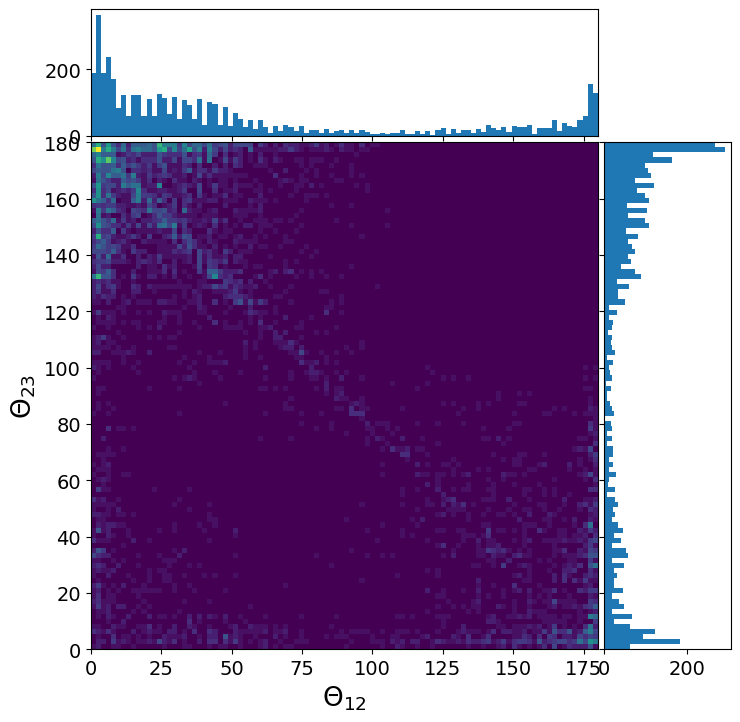

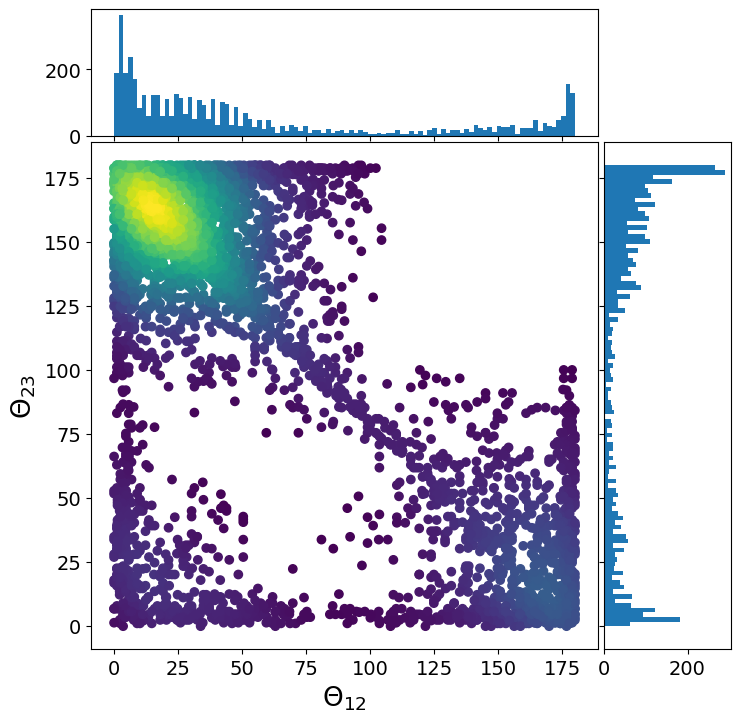

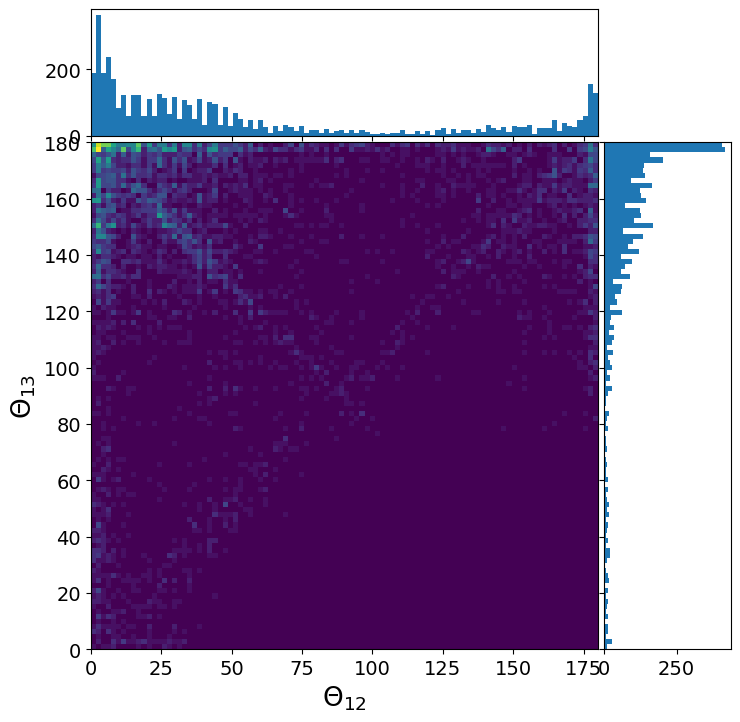

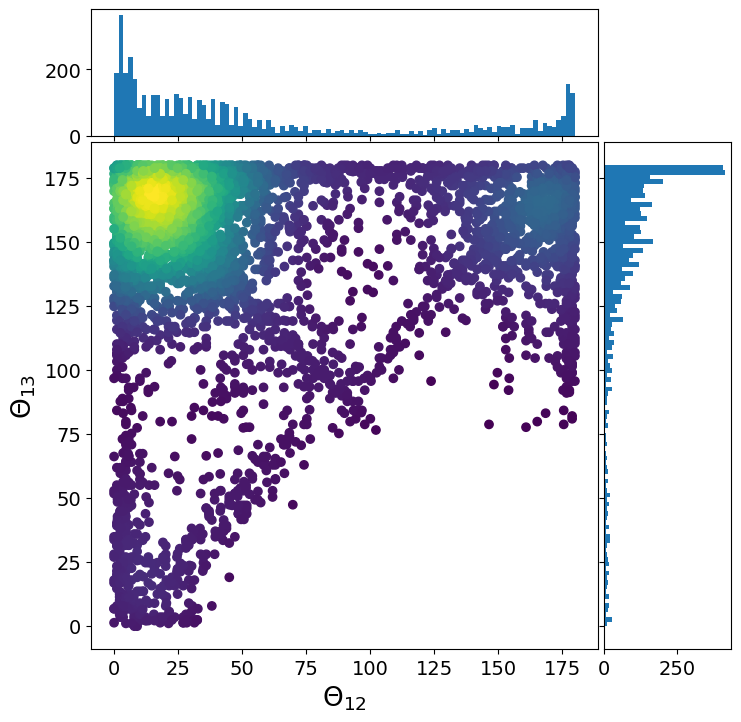

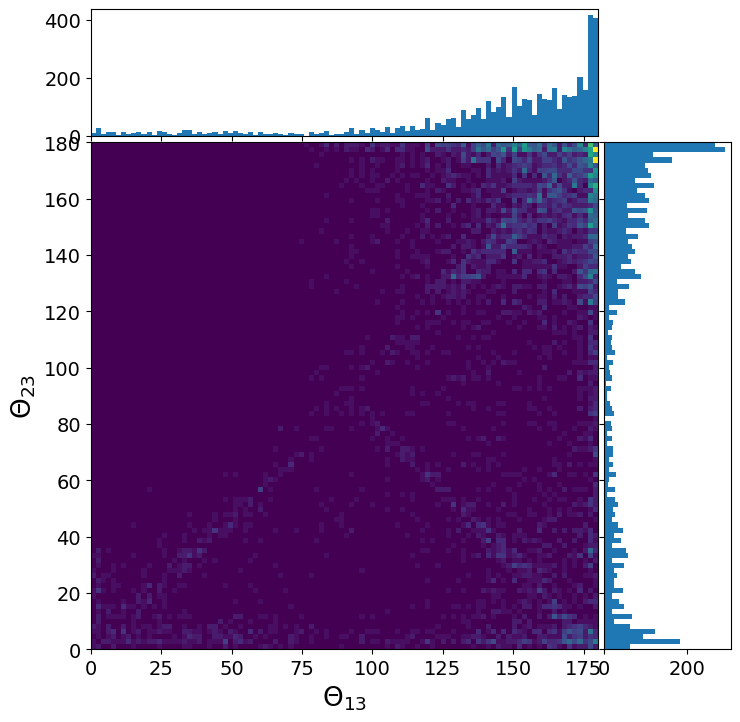

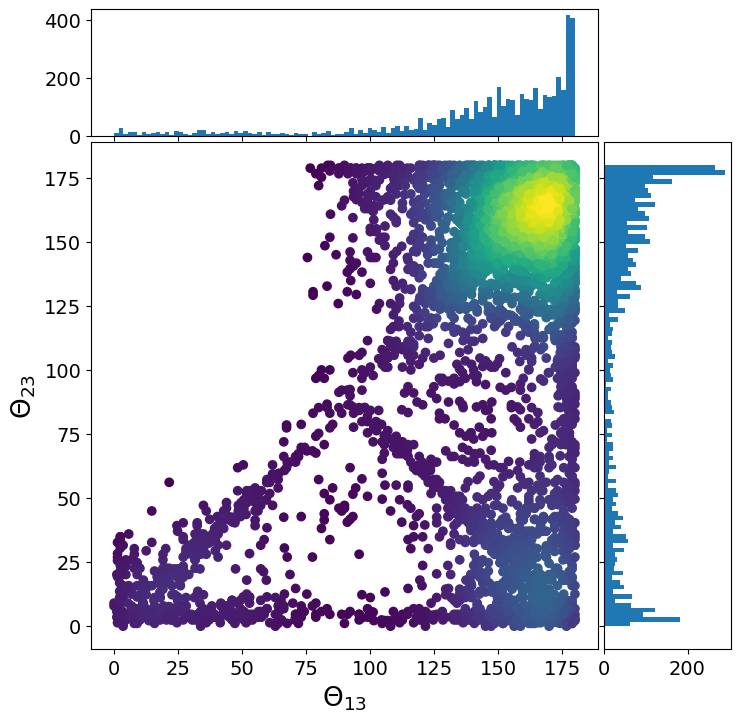

In [39]:
# and obtaining our pseudo-Dalitz plots
histProjection(theta12_nocut,theta23_nocut,100,labels = [r'$\Theta_{12}$',r'$\Theta_{23}$'])
scatterProjection(theta12,theta23,100,labels = [r'$\Theta_{12}$',r'$\Theta_{23}$'])

histProjection(theta12_nocut,theta13_nocut,100,labels = [r'$\Theta_{12}$',r'$\Theta_{13}$'])
scatterProjection(theta12,theta13,100,labels = [r'$\Theta_{12}$',r'$\Theta_{13}$'])

histProjection(theta13_nocut,theta23_nocut,100,labels = [r'$\Theta_{13}$',r'$\Theta_{23}$'])
scatterProjection(theta13,theta23,100,labels = [r'$\Theta_{13}$',r'$\Theta_{23}$'])

## conservation of momentum plot
* this is the money plot! --> true o-Ps candidates will sit around $\theta_{2} - \theta_{1} \le 25$˚ and $\theta_{2} + \theta_{1} \ge 200$˚

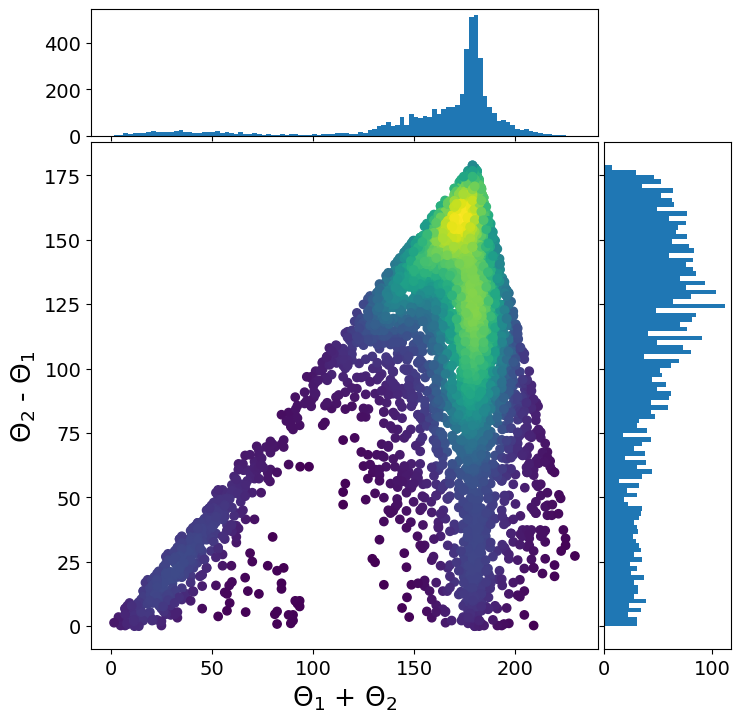

In [41]:
smallest = []
secondsmallest = []
for i,j,k in zip(theta12_nocut,theta13_nocut,theta23_nocut):
    sortedAngles = np.sort([i,j,k])
    smallest.append(sortedAngles[0])
    secondsmallest.append(sortedAngles[1])

smallest = np.array(smallest)
secondsmallest = np.array(secondsmallest)
scatterProjection(secondsmallest + smallest,secondsmallest - smallest,bins = 100,labels = [r'$\Theta_{1}$ + $\Theta_{2}$',r'$\Theta_{2}$ - $\Theta_{1}$'])
